In [1]:
import sys
sys.path.extend(['..', '../bprime'])
    
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
import re
import time
import pickle
import json
from multiprocessing import Pool
import itertools
from collections import defaultdict
import scipy.stats as stats

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from bprime.utils import index_cols
from bprime.sim_utils import fixed_params, get_bounds
from bprime.plots import surface_plot
from bprime.learn import LearnedFunction, LearnedB
from bprime.theory import bgs_segment, bgs_rec
from bprime.plots import bhat_plot, loss_plot, loss_limits_plot
from bprime.plots import b_learn_diagnostic_plot, rate_plot, arch_loss_plot
from bprime.nb_utils import load_learnedfuncs_in_dir
os.environ["CUDA_VISIBLE_DEVICES"]="1,1"

In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')

## Data

In [4]:
FIT_DIR = '../data/msprime_sims/fits/simple'
res = load_learnedfuncs_in_dir(FIT_DIR)

2022-04-19 12:49:58.227952: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_INVALID_DEVICE: invalid device ordinal
2022-04-19 12:49:58.227993: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: sesame
2022-04-19 12:49:58.228000: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: sesame
2022-04-19 12:49:58.228136: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 440.100.0
2022-04-19 12:49:58.228160: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 440.100.0
2022-04-19 12:49:58.228165: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 440.100.0
2022-04-19 12:49:58.229900: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performa

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


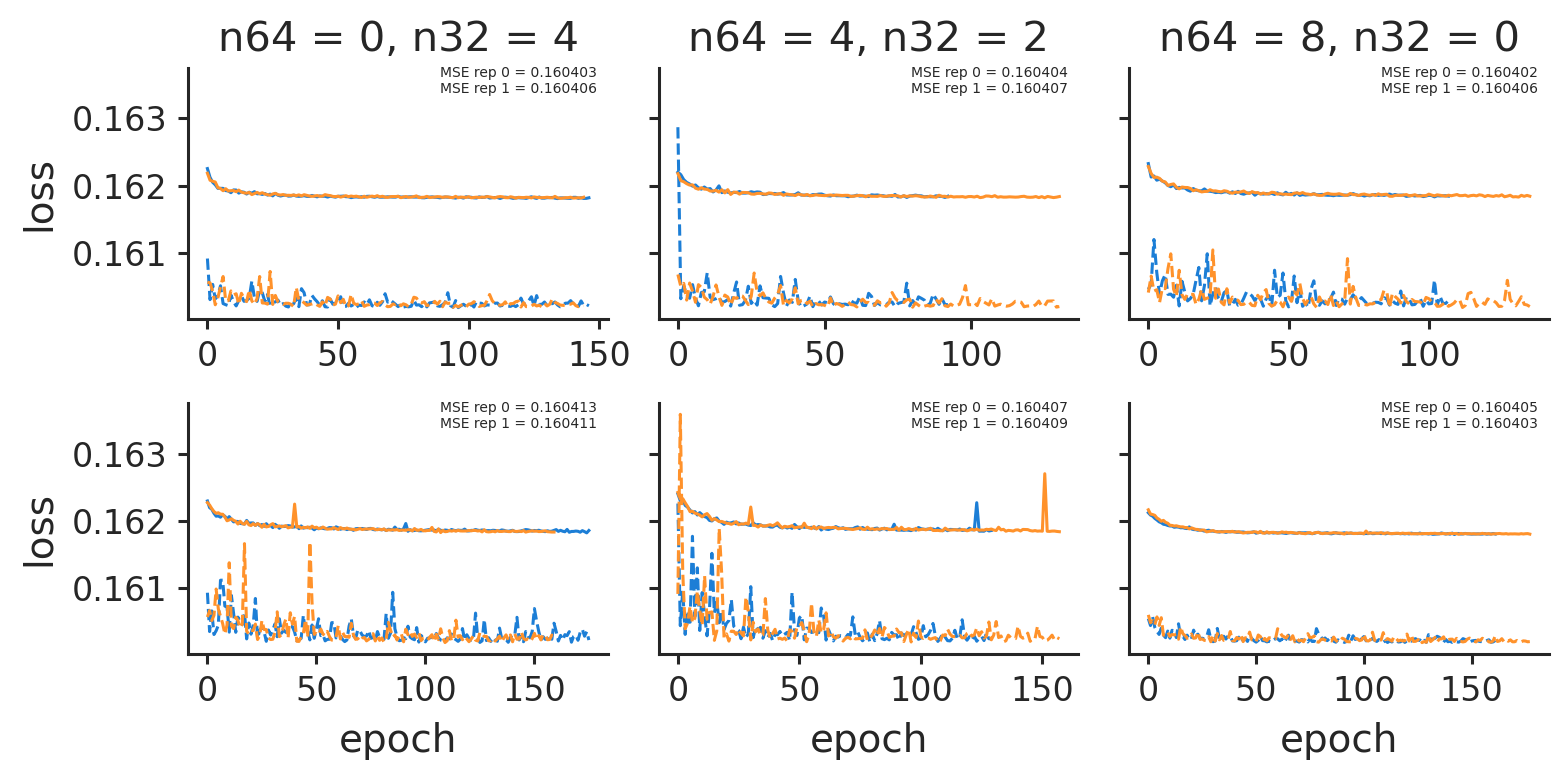

In [5]:
arch_loss_plot(res)

Really not much of a difference here -- it's fairly insensitive to the architecture for this simple function.

In [6]:
res.keys()

dict_keys([(0, 4), (4, 2), (8, 0), (8, 4), (8, 8), (0, 2)])

In [7]:
best_func = res[((8, 4))][0]

b = LearnedB(model='rec')
b.func = best_func

making 100x100 grid...	done.
313/313 [==============================] - 0s 1000us/step
using cached predictions
using cached predictions
using cached predictions


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


(<Figure size 2000x1400 with 4 Axes>,
 ((<AxesSubplot:>, <AxesSubplot:xlabel='epoch', ylabel='MSE'>),
  (<AxesSubplot:xlabel='binned $B_\\mathrm{ML}$', ylabel='$\\hat{B}$'>,
   <AxesSubplot:xlabel='predicted', ylabel='validation loss'>)))

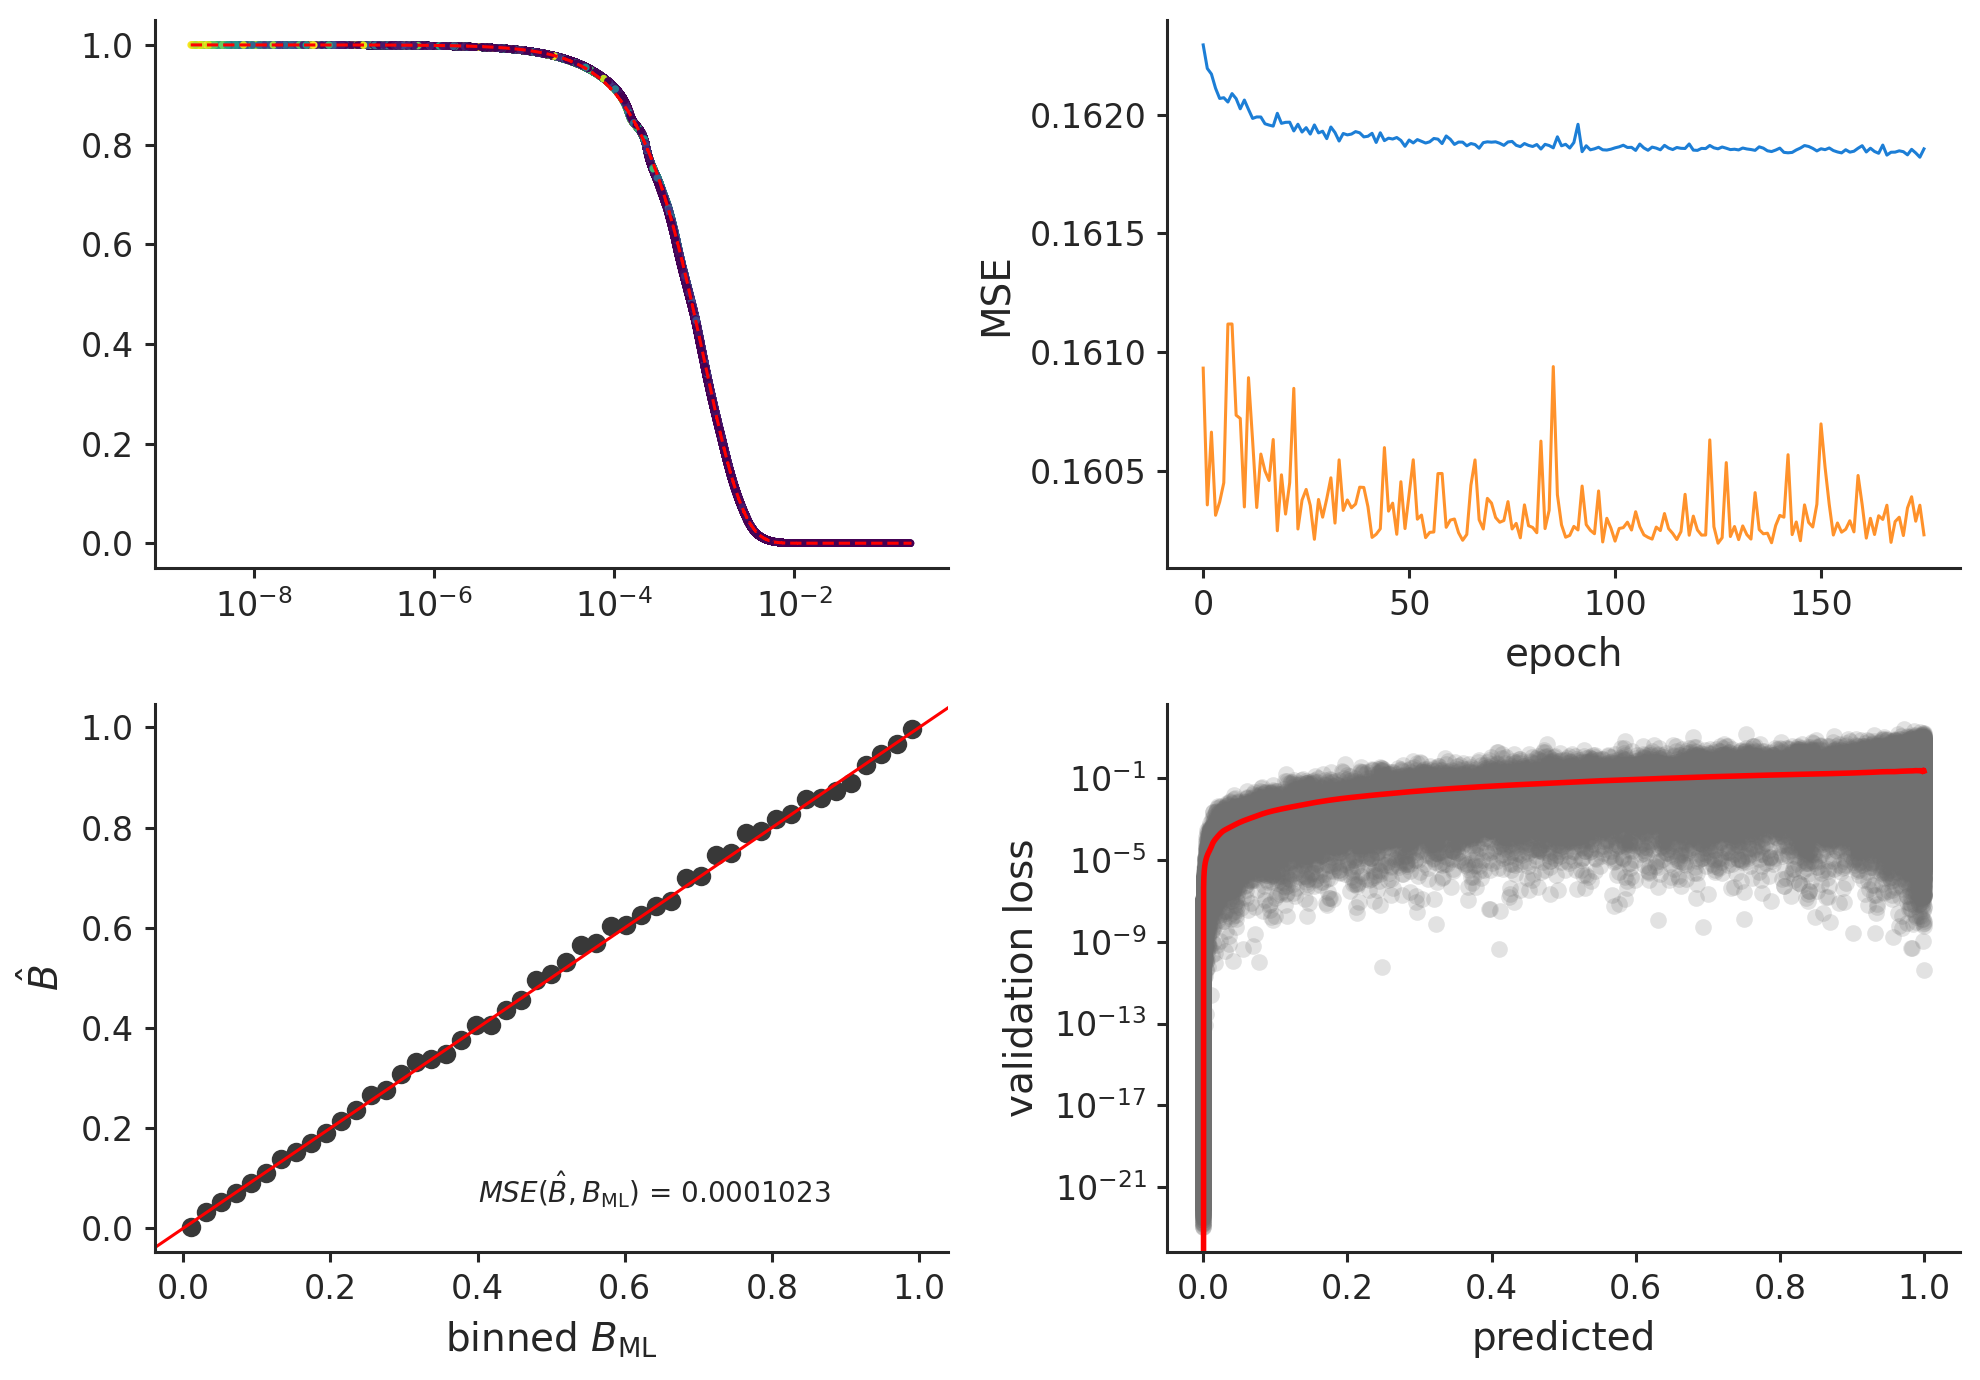

In [8]:
b_learn_diagnostic_plot(b, n={'mu': 100, 'sh': 100}, c='sh')

In [9]:
FIT_DIR = '../data/msprime_sims/fits/simple_varL_varrbp/'
res = load_learnedfuncs_in_dir(FIT_DIR)

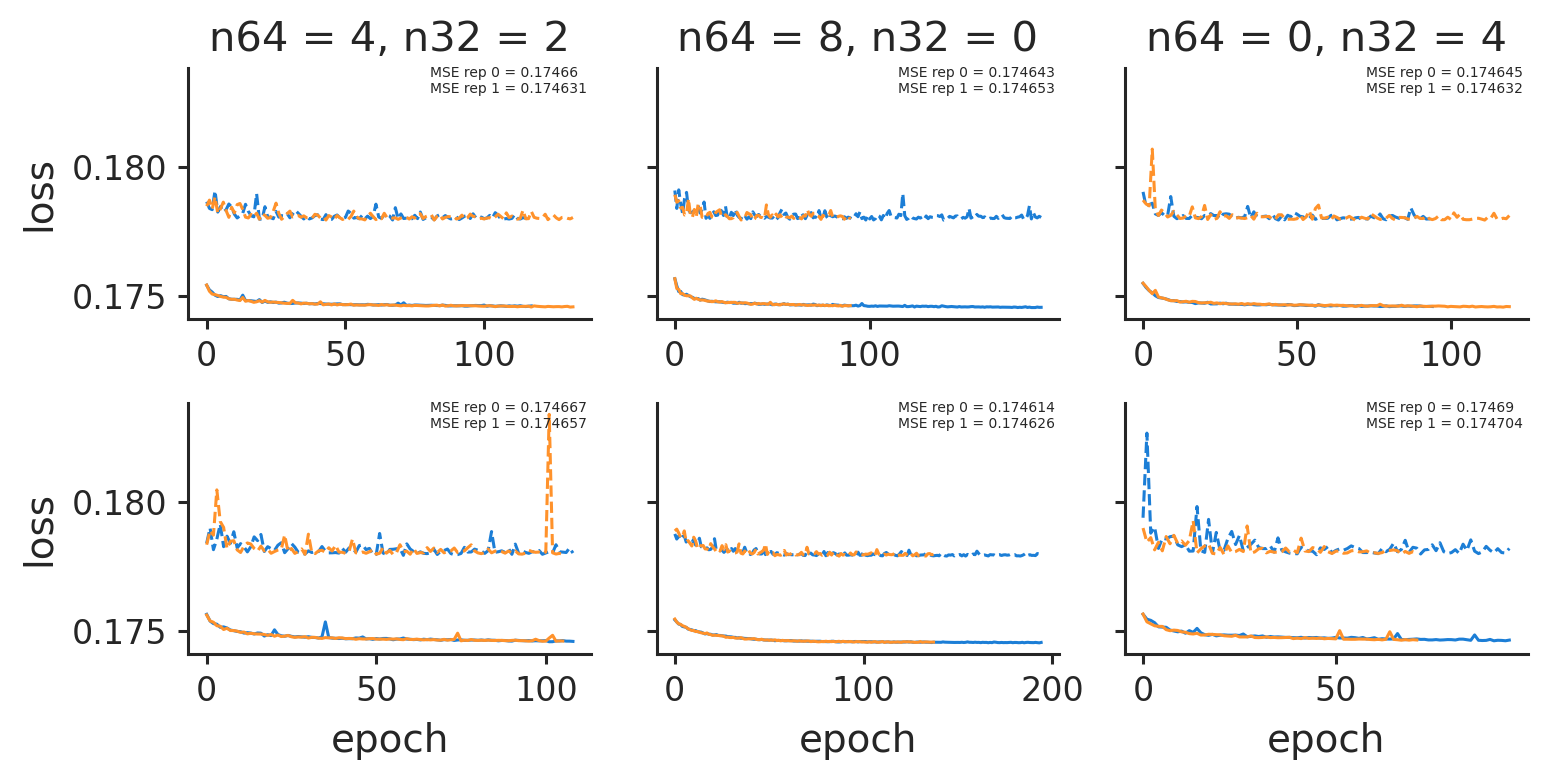

In [10]:
arch_loss_plot(res)

In [11]:
best_func_varL_varrbp = res[((8, 4))][0]

bLrbp = LearnedB(model='rec')
bLrbp.func = best_func_varL_varrbp

using cached predictions
using cached predictions
using cached predictions


(<Figure size 2000x1400 with 4 Axes>,
 ((<AxesSubplot:>, <AxesSubplot:xlabel='epoch', ylabel='MSE'>),
  (<AxesSubplot:xlabel='binned $B_\\mathrm{ML}$', ylabel='$\\hat{B}$'>,
   <AxesSubplot:xlabel='predicted', ylabel='validation loss'>)))

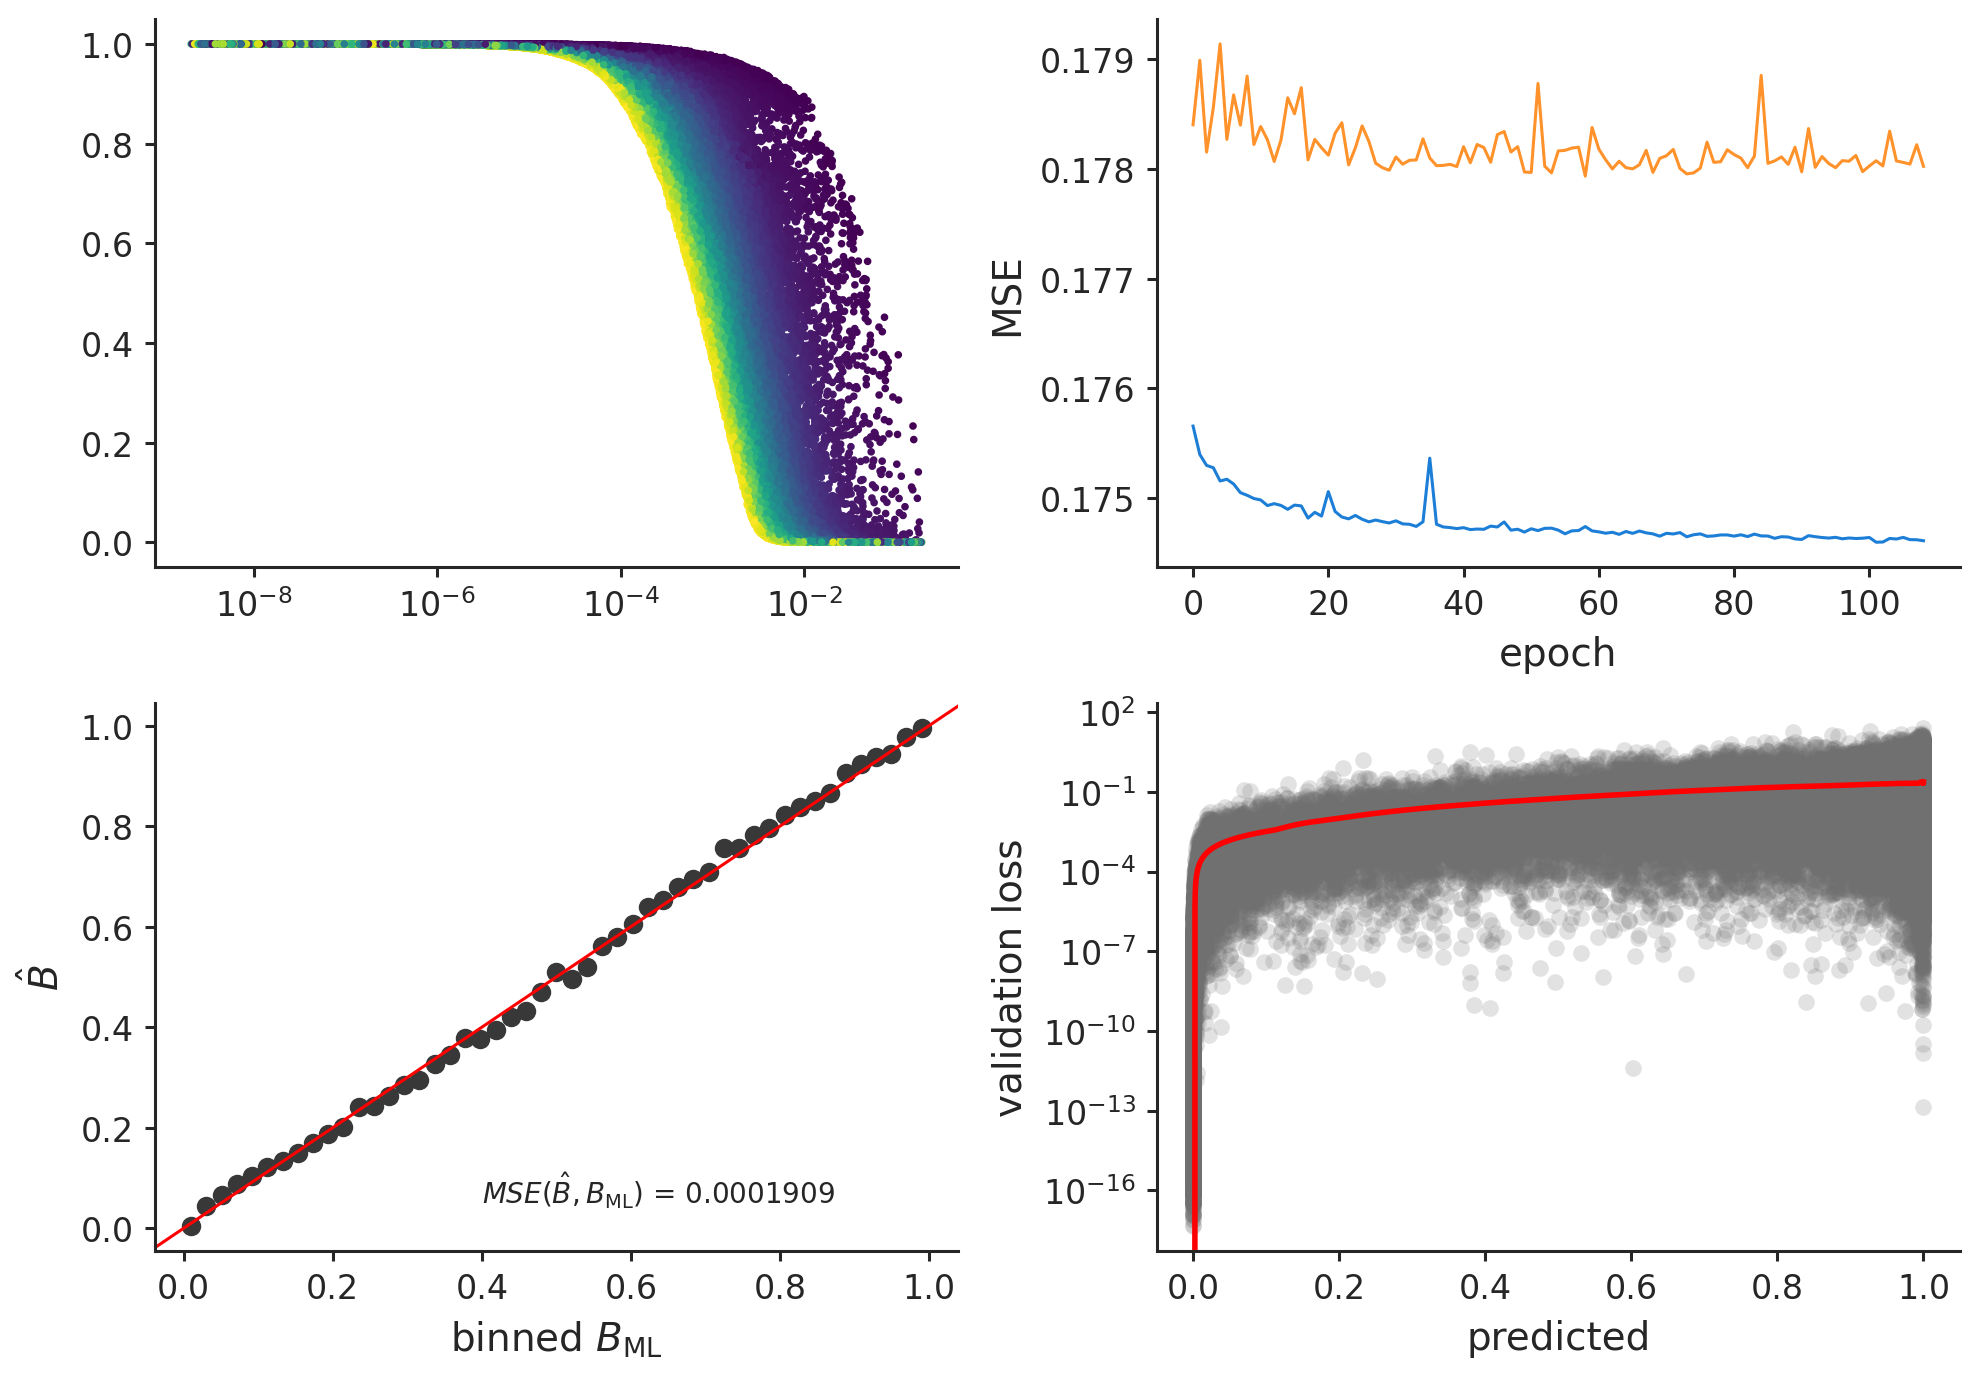

In [12]:
b_learn_diagnostic_plot(bLrbp, n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10}, c='L', add_theory=False)

In [66]:
FIT_DIR = '../data/msprime_sims/fits/segment_largesample/'
res = load_learnedfuncs_in_dir(FIT_DIR)

(<Figure size 1600x800 with 6 Axes>,
 <AxesSubplot:title={'center':'n64 = 8, n32 = 4'}, xlabel='epoch'>)

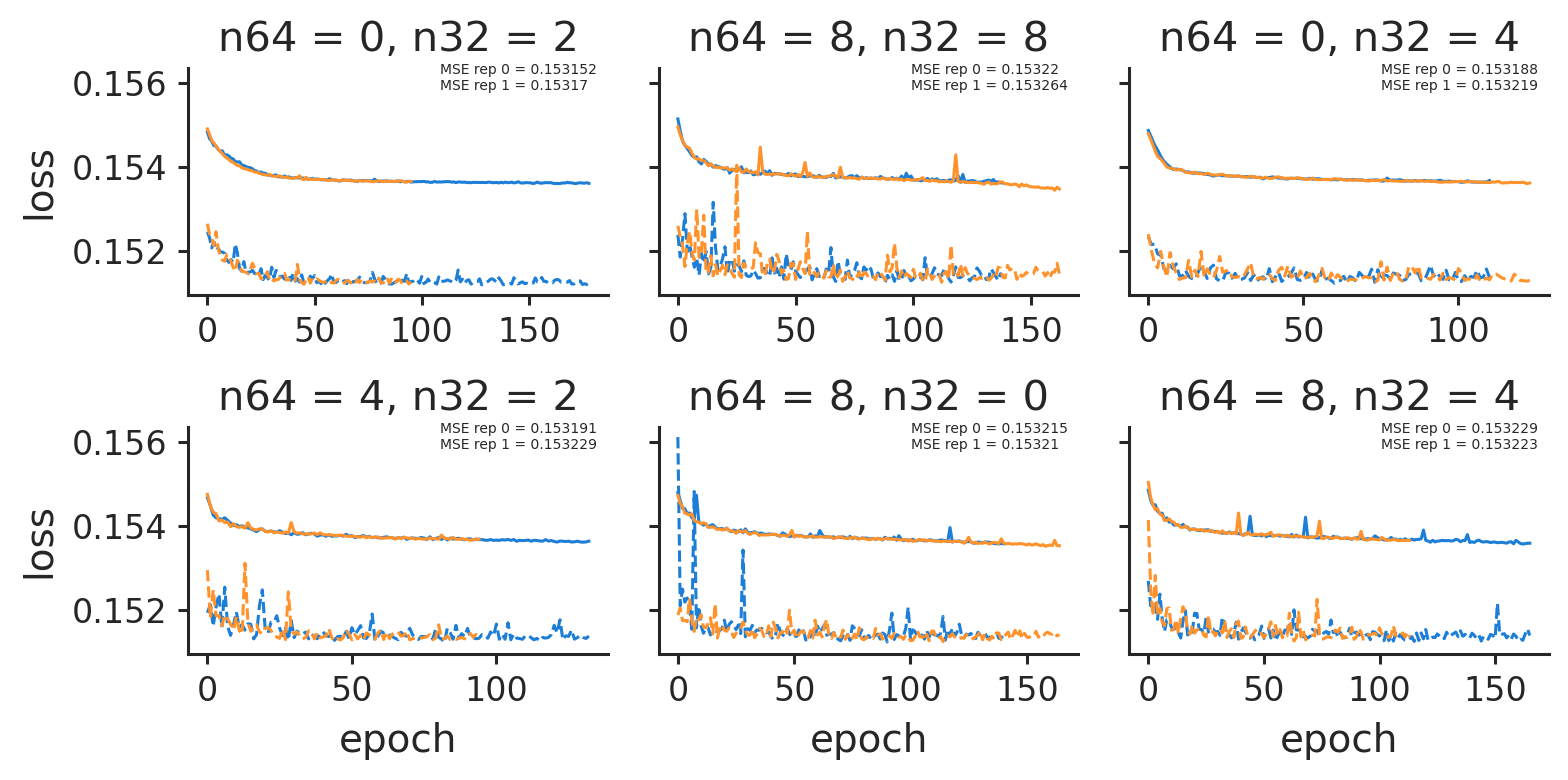

In [67]:
arch_loss_plot(res)

In [68]:
best_func_seg = res[((0, 2))][0]

bseg = LearnedB(model='segment')
bseg.func = best_func_seg

using cached predictions
using cached predictions
using cached predictions


(<Figure size 2000x1400 with 4 Axes>,
 ((<AxesSubplot:>, <AxesSubplot:xlabel='epoch', ylabel='MSE'>),
  (<AxesSubplot:xlabel='binned $B_\\mathrm{ML}$', ylabel='$\\hat{B}$'>,
   <AxesSubplot:xlabel='predicted', ylabel='validation loss'>)))

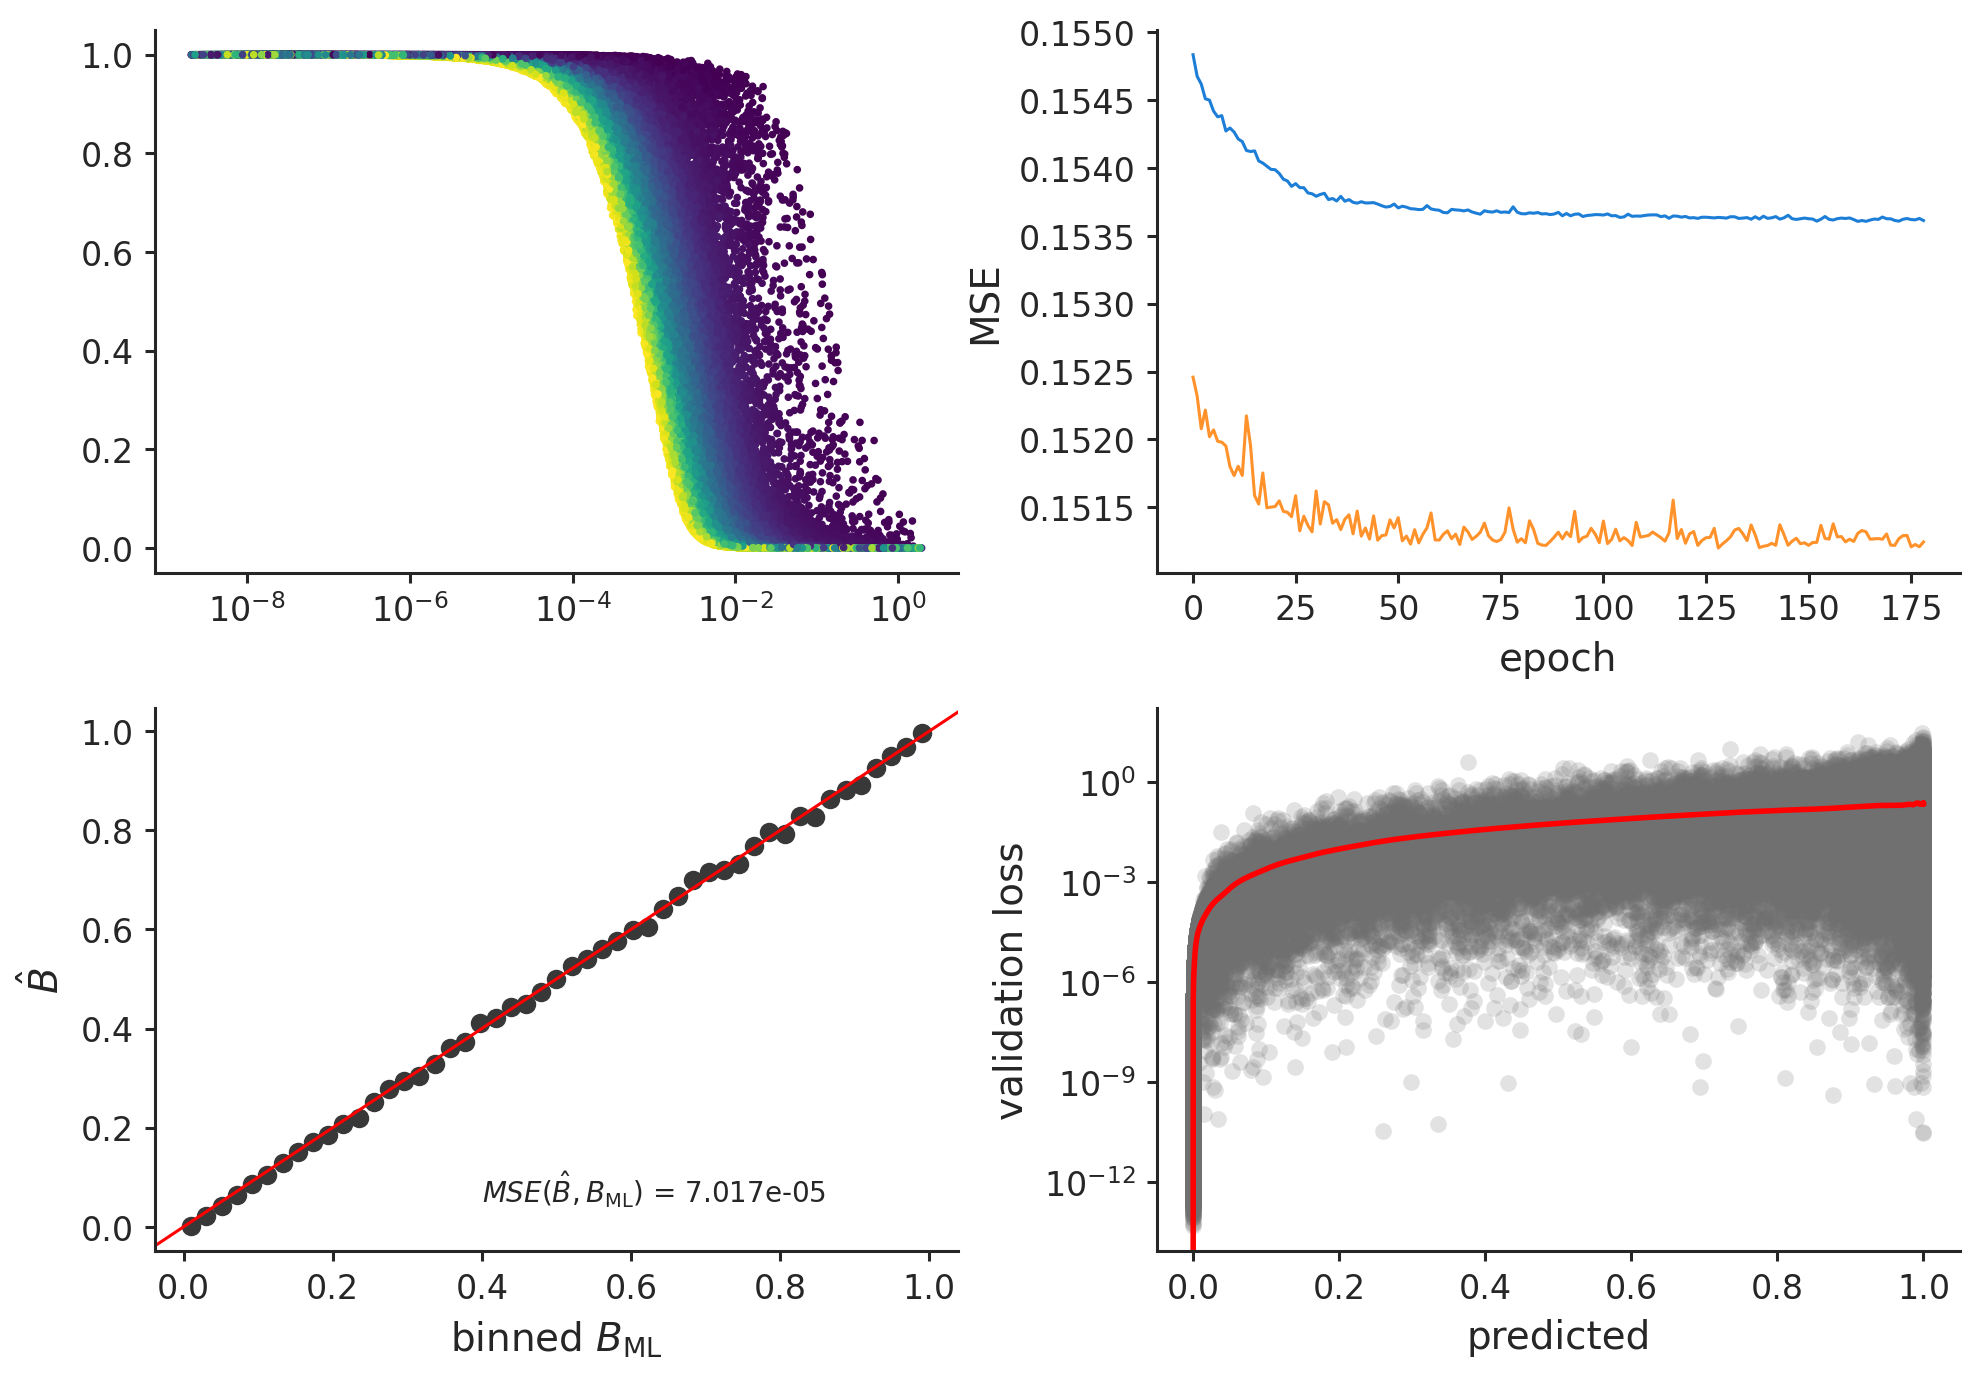

In [69]:
b_learn_diagnostic_plot(bseg, n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10, 'rf': 10}, c='L', add_theory=False)

using cached predictions


AttributeError: 'numpy.ndarray' object has no attribute 'get_array'

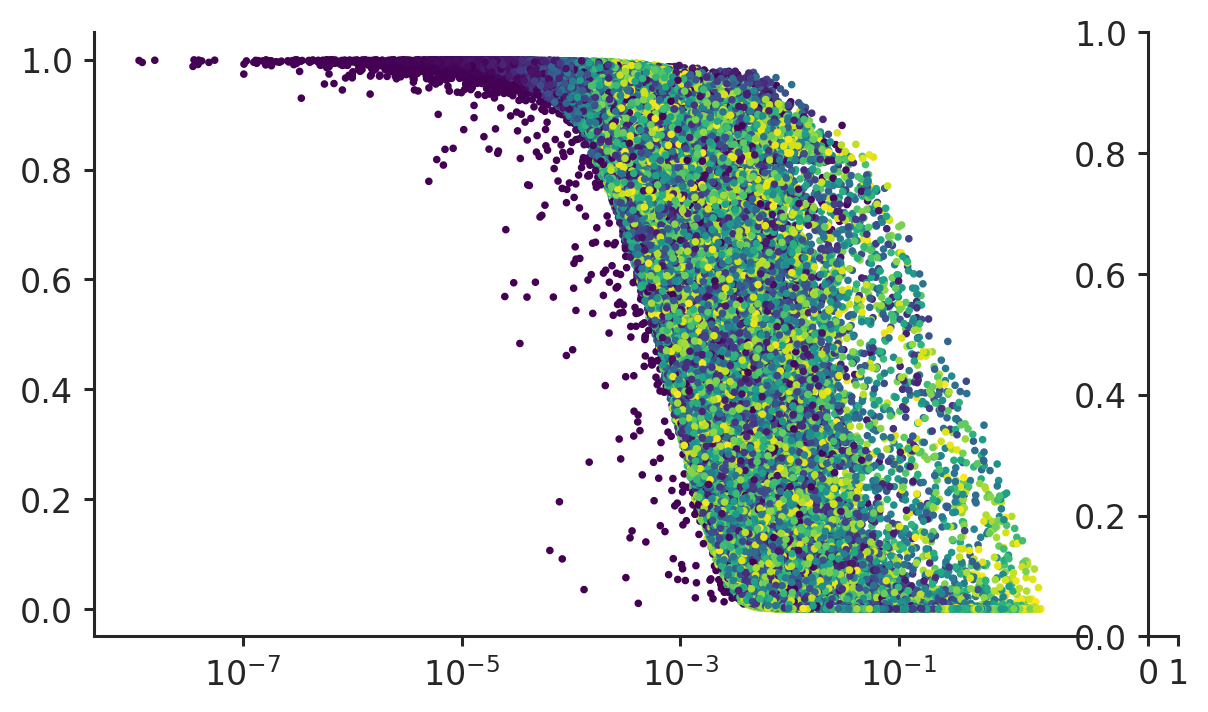

In [58]:
fig, ax = rate_plot(bseg, n={'mu': 10, 'sh': 10, 'L':10, 'rbp':10, 'rf': 10}, c='mu', add_theory=False)
fig.colorbar()